# Vehicle Detection using HOG and SVM

## 1. Purpose
The goals / steps of this project are the following:

+ Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
+ I also apply a color transform and append binned color features, as well as histograms of color, to my HOG feature vector.
+ Normalize my features and randomize a selection for training and testing.
+ Implement a sliding-window technique and use my trained classifier to search for vehicles in images.
+ Run my pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
+ Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
import numpy as np
import cv2
import math
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 

## 2. Helper Function for feature extraction
In addition to the Histogram of Oriented Gradient (HOG) for feature extractions, I also apply spatial binned color features as well as the histograms of color to my HOG feature vectors. 

Function **bin_spatial()** defined below is for spatial binned color features.  While it could be cumbersome to include the three color channels of a full resolution image, however, I can perform a smaller spatial binning on an image and still able to retain enough information in the image to help in finding vehicles.  In this approach, I reduce full resolution image to the size of (32,32) spatial bin.

The second method which I also use in this feature extraction is to apply the histogram of color. Histogram of color is useful in the case when objects in the image appear slightly different in aspects and orientations are still be matched which maybe helpful in the cases of vehicle detections.  The function **color_hist()** defined below is for histogram of color feature extraction.  Basically, in this function, I compute the histogram of the three channels (RGB) for a given image separately, then I concatenate them together to create a long feature vector which later can be use in the HOG feature extraction. This function also provide an option for plotting the histogram of color for three channel Red, Green, and Blue.

The main method for feature extraction is the Histogram of Oriented Gradient (HOG). Unlike the other methods which I described earlier, this HOG is the good for distinguish the gradient features. The function **get_hog_features()** describes how I can extract feature using HOG method.  The essential thought behind the histogram of oriented gradients descriptor is that local object appearance and shape within an image can be described by the distribution of intensity gradients or edge directions. The image is divided into small connected regions called cells, and for the pixels within each cell, a histogram of gradient directions is compiled. The descriptor is the concatenation of these histograms. For improved accuracy, the local histograms can be contrast-normalized by calculating a measure of the intensity across a larger region of the image, called a block, and then using this value to normalize all cells within the block. This normalization results in better invariance to changes in illumination and shadowing.  I use orient = 9, pix_per_cell = 8, cell_per_block = 2 in this HOG method in this project because It seems to give me a best result without picking up lots of false positives.  There are also another important factors, which I will describe later in the following sections, also help in feature extraction for vehicle detection.

Lastly, I combine feature vectors of all three methods (spatial binned color, histogram of color, and HOG) as described in the function **extract_features()**.  This is the final combined feature vectors prior to fit in the Support Vector Machine algorithm (SVM) for vehicle/non-vehicle classification.  One thing that I also need  to mention that in this project, I use the 'YCRCB' color space.  I have tried other color spaces like 'RGB', 'LUV', 'HLS', but this color space seems to give me the best results.



In [2]:
# While it could be cumbersome to include three color channels of a full resolution 
# image, you can perform spatial binning on an image and still retain enough information 
# to help in finding vehicles. 
def bin_spatial(img, size=(32, 32), print_flag = 'no'):
    """
    resize image to a desize size and 
    fatten out to a feature vector.
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    if (print_flag == 'yes'):
        plt.plot(features)
        plt.title('Spatially Binned Features')
    # Return the feature vector
    return features


# Histogram of Color is useful in the case when objects appear slightly different in aspects and orientations
# are still be matched.
def color_hist(img, nbins=32, bins_range=(0, 256), print_flag = 'no'):
    """
    find color histogram for RGB channels and concatenate to a feature vector.
    Plot to visual R,G,B histogram graphs.
    """
    # Compute the histogram of the color channels separately
    rhist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    # Plot a figure with all three bar charts
    if (print_flag == 'yes'):
        if (rhist is not None) or (ghist is not None) or (bhist is not None):
            fig = plt.figure(figsize=(12, 3))
            plt.subplot(131)
            plt.bar(bin_centers, rhist[0])
            plt.xlim(0, 256)
            plt.title('R Histogram')
            plt.subplot(132)
            plt.bar(bin_centers, ghist[0])
            plt.xlim(0, 256)
            plt.title('G Histogram')
            plt.subplot(133)
            plt.bar(bin_centers, bhist[0])
            plt.xlim(0, 256)
            plt.title('B Histogram')
            plt.show()
        else:
            print('Your function is returning None for at least one variable...')
    # Return the individual histograms, bin_centers and feature vector
    return hist_features




# HOG is good for distinguish gradient features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, print_flag='no'):
    """
    Given orientations, pixels_per_cell and cell_per_block, compute the hog features 
    of a image.
    If visual option is True, we can display the hog image on the graph.
    """
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        if (print_flag == 'yes'):
            # Plot the examples
            fig = plt.figure()
            plt.subplot(121)
            plt.imshow(img, cmap='gray')
            plt.title('Example Car Image')
            plt.subplot(122)
            plt.imshow(hog_image, cmap='gray')
            plt.title('HOG Visualization')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


    
# Method to combine all three sptial binning, histogram of color, and HOG features    
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """
    Method to convert image to different color space and combine hog feature, histogram 
    of color features, and spatial bin color features into a single feature vector
    """
    
    # Create a list to append feature vectors
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCRCB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range = hist_range)
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(np.concatenate((hog_features,spatial_features,hist_features)))
    # Return list of feature vectors
    return features    
    

## Data Exploration
Before fitting feature vectors of provided car and non-car dataset into the SVM for vehicle classification, I need to visualize and understand these dataset.  From the exploration, the numbers of car and non-car images in both dataset seem to be about the same size (Number of car images:  8792, Number of non-car images:  8968) which mean that one dataset will not be dominant over the other, and I don't have to augment for more data in any dataset. 

As seen below, the images in the car and non-car dataset are properly displayed.  There is no mismatch of images from one dataset to the other dataset.

#### (a). Plot car and non-car image

Number of car images:  8792
Number of non-car images:  8968


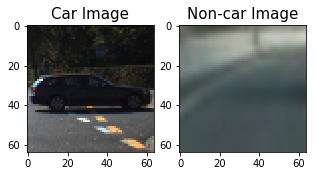

In [3]:
# Load cars and non-cars dataset
car_files = glob.glob('vehicles/vehicles/*/*.png')
noncar_files = glob.glob('non-vehicles/non-vehicles/*/*.png')
print("Number of car images: ",len(car_files))
print("Number of non-car images: ",len(noncar_files))
# randomize the index of cars and noncars dataset
car_idx = np.random.randint(len(car_files) - 1)
noncar_idx = np.random.randint(len(noncar_files) - 1)

img_car = mpimg.imread(car_files[car_idx])
img_noncar = mpimg.imread(noncar_files[noncar_idx])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.5))
ax1.imshow(img_car)
ax1.set_title('Car Image',fontsize=15)
ax2.imshow(img_noncar)
ax2.set_title('Non-car Image', fontsize=15)


#### (b). Visualize Hog, Color Histogram and Spatial Binned Features for a car image

Below is the plot of the spatial binning of color for the car image above.  Notice that it is in the range of (0,1) because I use the `mpimg.imread` from the matplotlib.image to read in the car image.

In [4]:
# Just create a HOG parameters to display the HOG image/features
colorspace = 'YCRCB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

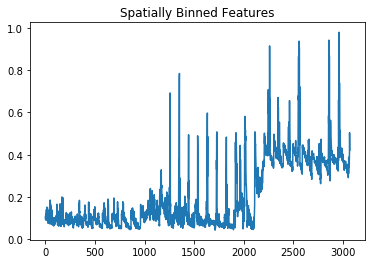

In [5]:
# spatial binning of car image
bin_features = bin_spatial(img_car, size=(32, 32), print_flag = 'yes')

HOG visualization below with gradient directions are shown.  As you can see the shape of the car is almost standout in the HOG visualization plot. 

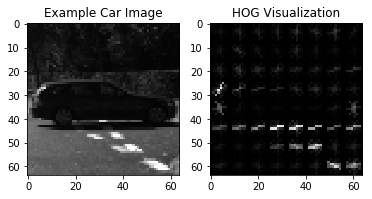

In [6]:
# HOG features
img_car = img_car[:,:,0]
hog_car = get_hog_features(img_car, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block= cell_per_block, vis=True, feature_vec=False, 
                                print_flag='yes')

#### (c). Visualize combined and normalized features for a car and non-car image
Below is the combined feature vectors of the car and non-car before normalization and after normalization.

In [7]:
car_features = extract_features(car_files, cspace=colorspace,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(noncar_files, cspace=colorspace,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel)
print ('Notcar samples: ', len(notcar_features))

Car samples:  8792
Notcar samples:  8968


car index:  3956


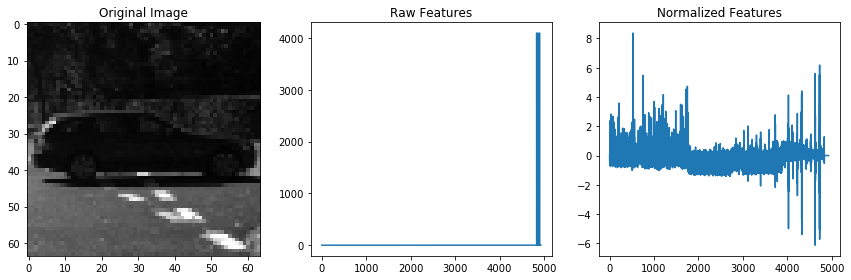

In [8]:
# Create an array stack of feature vectors
x = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
x_scaler = StandardScaler().fit(x)
# Apply the scaler to X
scaled_x = x_scaler.transform(x)
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(img_car, cmap='gray')
plt.title('Original Image')
plt.subplot(132)
print('car index: ', car_idx)
plt.plot(x[car_idx])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_x[car_idx])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

## SVM Training
The algorithm which I'm going to use to detect the car vs. non-car is the linear Support Vector Machine algorithm (SVM) as described in the below function **svm()**.  

In this **svm()** function, the combined feature vectors which are extracted from the function **extract_features()** for both car and non-car dataset are stacked in a long vertical feature array and are normalized prior to fit in the Support Vector Machine algorithm (SVM) for vehicle/non-vehicle classification.

The normalized feature vectors also need to randomly split into the train, test sets with the aspect ratio of 20/80 percents, and the labels for the car and non-car dataset are also created.  

Here is my final parameters which I use to train this SVM model:

`colorspace = YCRCB # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)
hist_range = (0,256)
hist_bins = 32`

The results to train svm model for the two car and non-car dataset as shown:

`35.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
0.00531 Seconds to predict 10 labels with SVC`

Finally, the parameters of the svm is saved in a pickle file for later use.

In [9]:
#Final parameters 
colorspace = 'YCRCB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)
hist_range = (0,256)
hist_bins = 32


def svm (car_files,noncar_files,cspace=colorspace,spatial_size=spatial_size,hist_bins=hist_bins, 
         hist_range=hist_range,orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
         hog_channel=hog_channel):
    """
    Stack car and non-car feature vectors and normalize them before fitting into a Linear SVM.
    Give SVM prediction and compute time for both SVM train and prediction.
    """
    
    car_features = extract_features(car_files, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    noncar_features = extract_features(noncar_files, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC 
    svc = LinearSVC()
    
    # Training for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    #save svc model
    pickle_svc = {}
    pickle_svc['X_scaler'] = X_scaler
    pickle_svc['svc'] = svc
    pickle.dump(pickle_svc, open('pickle_svc.p', 'wb'))


In [10]:
svm_train = svm(car_files,noncar_files,cspace=colorspace,spatial_size=spatial_size,hist_bins=hist_bins, 
         hist_range=hist_range,orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
         hog_channel=hog_channel)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
32.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
0.00309 Seconds to predict 10 labels with SVC


## Image Processing
In this section, I'm going to use the Hog Sub-sampling window search technique to
do the sliding window approach which allows me to only have to extract the Hog features once.
The code below defines a single function **find_cars()** that's able to both extract features 
and make predictions. 
The function **find_cars()** only has to extract hog features once and then can be sub-sampled 
to get all of its overlaying windows. Each window is defined by a scaling factor where a scale 
of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of 
the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. 

The function actually defines and picks out the ROI on the image where the vehicles will be detected and tracked.
Depends on the scale which I choose, it then resize and splits the ROI into three separate channels and compute the 
numbers of blocks and steps in x/y coordinates for the sliding windows.  When the numbers of sliding steps 
in x/y coordinate are determined, for each sliding step, I then extract the hog features, spatial binned color features,
as well as the histogram of color features, stack them up and run through the pre-defined svm algorithm to predict for car vs. non-car.
If the algorithm predicts the car in the ROI in the image, then I will draw a bounding box around the car image.  
In this project, this settings:

`orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_range = (0,256)
hist_bins = 32
ystart = 400
ystop = 656
scales = 1.5
threshold = 1.5`

give me the best results which minimize most of the false positive.

#### Helper Functions for Image Processing
The heatmap technique in the funciton **add_heat()** is very simple.  Very time it detects a bounding box, it will add one to it.  

Using this heatmap technique I can remove the false positives if I set some number of threshold for the heatmap (as shown in the **apply_threshold() function**) because the false positive normally won't 
occur in the consequence frames.  

Once I have a thresholded heat-map, there are many ways I could go about trying to figure out how many cars I have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the label() function from scipy.ndimage.measurements. The labels is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.  Now, I can take my labels image and put bounding boxes around the labeled regions.  This all described in the function **draw_labeled_bboxes()**

In [19]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    color conversion for a image to different color space
    """
    
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    
def add_heat(heatmap, bbox_list):
    """
    Add one to the heatmap for every bounding box.
    """
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    """
    Apply heatmap threshold.  Zero out pixels if below the threshold.
    """
    
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
    Base on the image labels, draw a bounding box around objects.
    """
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 3)
    # Return the image
    return img

#### Function that extract cars in the image

In [12]:
# Function that can extract features using hog sub-sampling
def find_cars(img, ystart, ystop, scale, X_scaler, svc, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, print_flag='no'):
    """
    This is the main pipeline to find a car.
    1. Define a ROI region to search for cars on the image.
    2. Scale image accordingly if scale is defined different than 1
    3. Split the image to separate channels
    4. Compute the hog features for the 3 image channels
    5. Define numbers of blocks, steps and window. For every image patch, compute the hog features
       for individual channel, stack them up, and combine with other color features.
    6. Predict the final feature using pre-define svm.
    7. Draw a rectangle bounding box around predicted features on image
    8. Return draw image and list of bounding box.
    """
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if (print_flag == 'yes'):
        plt.title('ROI to search for car')
        plt.imshow(img_tosearch)
    img_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        img_shape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
#         plt.title('ROI to search for car after applying scale')
#         plt.imshow(img_tosearch)
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),3) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img,bbox_list

#### Test with six test images
Take this algorithm and run through the 6 test images in the test_images directory, here  I'm showing all the bounding boxes 
for where my classifier reported positive detections. You can see that overlapping detections exist for each of the 
two vehicles, and in two of the frames, I find a false positive detection on the guardrail to the left.
In order to combine overlap detection and remove false positives, there is a very simple but useful technique called heatmap I described above which will help in remove false positives and combine overlap detection.

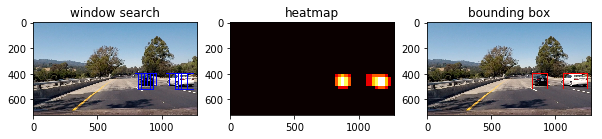

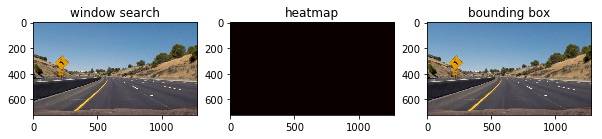

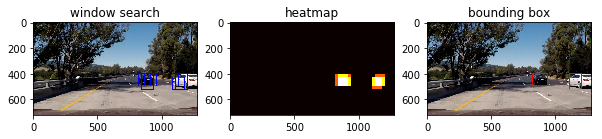

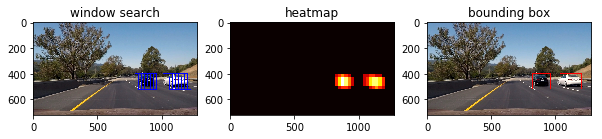

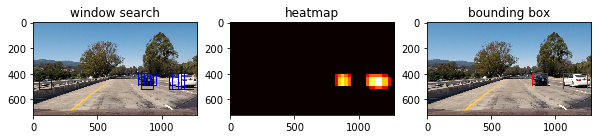

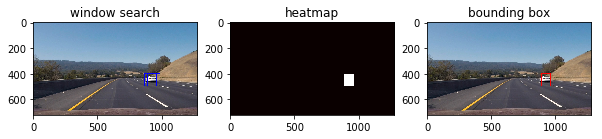

In [13]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_range = (0,256)
hist_bins = 32

ystart = 400
ystop = 656
scales = [1.5]
threshold = 1.5


#restore svc model and X_scaler
pickle_svc = pickle.load(open('pickle_svc.p', 'rb'))
svc = pickle_svc['svc']
X_scaler = pickle_svc['X_scaler']

test_files = glob.glob('test_images/*.jpg')


for test_file in test_files:
    test_img = mpimg.imread(test_file)
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    
    curr_img = np.copy(test_img)
    for curr_scale in scales:
        curr_img,box_list = find_cars(curr_img, ystart, ystop, curr_scale, X_scaler, svc, 
                                      orient, pix_per_cell, cell_per_block, spatial_size, 
                                      hist_bins, print_flag='no')
        heat = add_heat(heat,box_list)
        heat = apply_threshold(heat,threshold)
        heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(test_img), labels)
    
    f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))
    
    ax1.imshow(curr_img)
    ax1.set_title('window search')
    
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('heatmap')
    
    ax3.imshow(draw_image)
    ax3.set_title('bounding box')

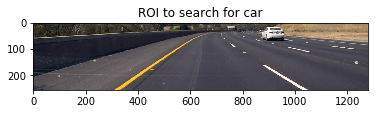

In [14]:
for test_file in test_files:
    test_img = mpimg.imread(test_file)
    _,_ = find_cars(test_img, ystart, ystop, curr_scale, X_scaler, svc, 
                                      orient, pix_per_cell, cell_per_block, spatial_size, 
                                      hist_bins, print_flag='yes')

## Video Processing
In this section of video processing, I run my pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

+ The output video of test_video.mp4 can be viewed at: https://www.youtube.com/watch?v=rvDBd1BpIic
+ The output video of project_video.mp4 can be viewed at: https://youtu.be/C8ZZFPCrrUQ

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#restore svc model and X_scaler
pickle_svc = pickle.load(open('pickle_svc.p', 'rb'))
svc = pickle_svc['svc']
X_scaler = pickle_svc['X_scaler']
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_range = (0,256)
hist_bins = 32
ystart = 400
ystop = 656
scales = [1.5]
threshold = 5
num_frames = 5   # number of frame in the queue



class HotWindows():
    """
    Keep track of n previous hot windows
    Compute cumulative heat map over time

    self.windows is a queue of lists of bounding boxes.
    The list can be of arbitrary size.
    
    Each element in the queue represents the list of
    bounding boxes at a particular time frame.
    """
    def __init__(self, n):
        """
        constructor of the HotWindows class.
        """
        self.n = n
        self.windows = []  

    def add_windows(self, new_windows):
        """
        Append new windows to queue
        Pop from queue if it is full
        """
        self.windows.append(new_windows)

        queue_full = len(self.windows) >= self.n
        if queue_full:
            _ = self.windows.pop(0)

    def get_windows(self):
        """
        Concatenate all lists in the queue and return the list
        """
        out_windows = []
        for window in self.windows:
            out_windows = out_windows + window
        return out_windows
    
    
hot_windows = HotWindows(num_frames)

def process_image(img):
    """
    Find the hot windows. Add the new windows from the new frame into the list
    until the queue is full.
    
    Compute the heatmap base on hot windows, apply the heatmap threshold and find the labels 
    Finally, draw the bounding box around objects.
    
    """
    global hot_windows

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    curr_img = np.copy(img)
    for curr_scale in scales:
        output_img,box_list = find_cars(curr_img, ystart, ystop, curr_scale, X_scaler, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # Add new hot windows to HotWindows queue
        hot_windows.add_windows(box_list)
        all_hot_windows = hot_windows.get_windows()

        # Calculate and draw heat map
        heat = add_heat(heat, all_hot_windows)
        heat = apply_threshold(heat, threshold)
        labels = label(heat)

        # Draw final bounding boxes
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        #draw_img = draw_labeled_bboxes(output_img, labels)
    return draw_img

In [16]:
white_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:25<00:00,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 56s, sys: 3.69 s, total: 2min
Wall time: 27.1 s


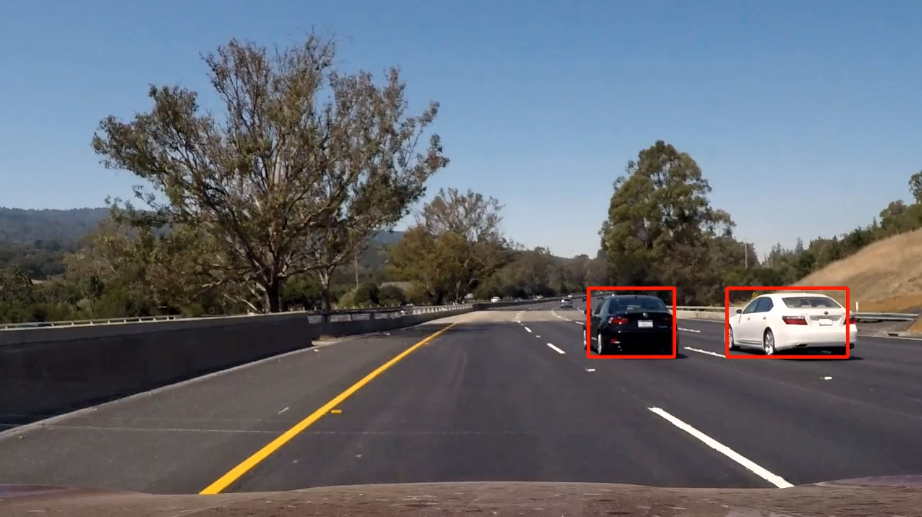

In [17]:
# video captured from test_video.mp4
PATH = "output_images/"
Image(filename = PATH + "test_video.png", width=400, height=700)

In [24]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [21:48<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 7min 46s, sys: 2min 3s, total: 1h 9min 49s
Wall time: 21min 50s


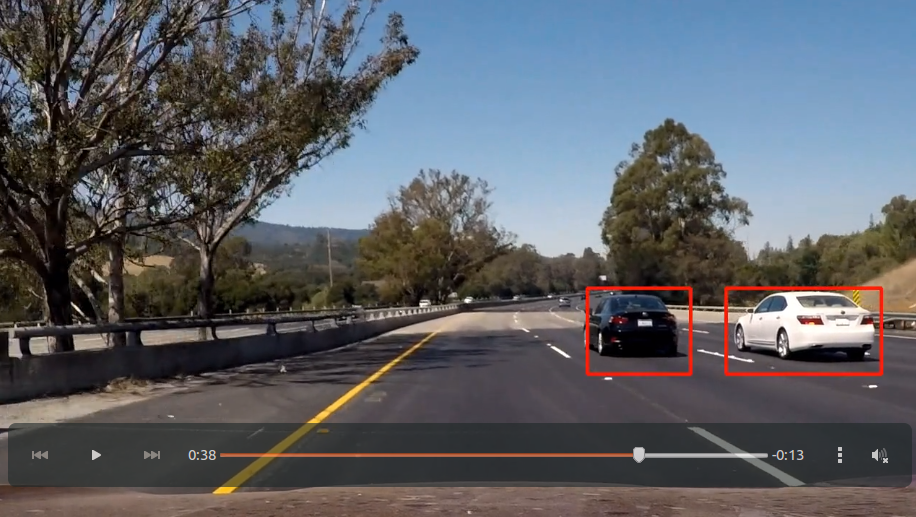

In [22]:
# video captured from project_video.mp4
PATH = "output_images/"
Image(filename = PATH + "project_video.png", width=400, height=700)

## Discussion
Vehicle detection and tracking using HOG and SVM algorithm considers to be hard to classify because there is so many parameters which I need to tune for HOG like: orient, pix_per_cell, and cell_per_block in addition to the parameters in the sliding window technique.  Intially, I get lots of false positives even though my svm score is very good (0.99) and my bounding box around the detected vehicles isn't very stable and shifting around so much.  With implementing  the `hot window` technique to keep track of previous frames and compute accumulative heatmap over time, I'm able to make my bounding box around the detected vehicles focused and stable.  

Currently, this HOG and SVM technique which I'm using currently trains under the flat surface road.  If this applies to the hill roads when the horizon changes over elevation, this algorithm may fail.

## Bonus
In this bonus section, I'm going to combine and create a video output of the Lane Detection (in Project 4) with this Vehicle Detection and Tracking.  
The output video can be viewed at: https://www.youtube.com/watch?v=UqATnQJQqgM

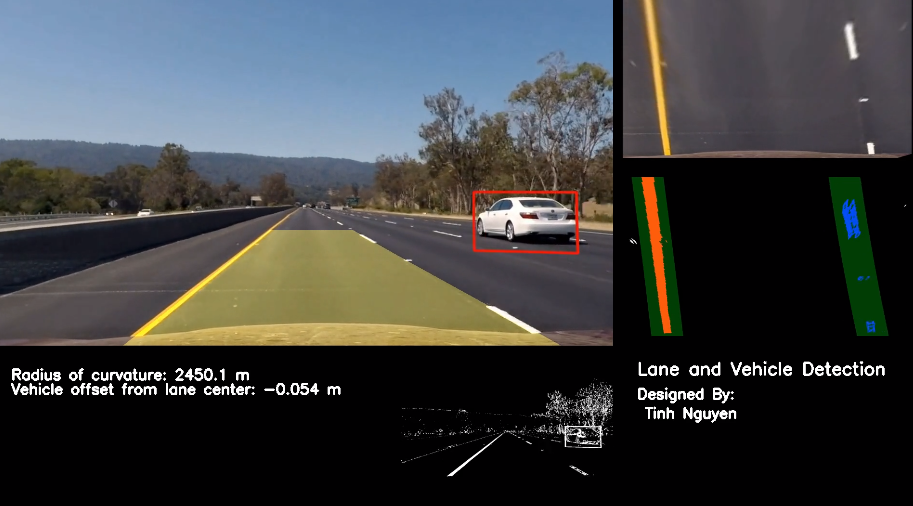

In [25]:
# video captured from project_video.mp4
PATH = "output_images/"
Image(filename = PATH + "bonus.png", width=400, height=700)